# Differential erosion through a dipping dyke

This notebook reproduces the [dipping dyke example](https://fastscape-lem.github.io/fastscapelib-fortran/#_dippingdyke_f90) provided in the fastscapelib-fortran library. It shows how to create custom processes for modelling differential erosion due to some structural (e.g., rock strengh) heterogeneity.

In [1]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape

%matplotlib inline

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import and inspect the model

We use the basic model available in [fastscape](https://fastscape.readthedocs.io/en/latest/).

In [3]:
from fastscape.models import basic_model

Let's create a new process class to model the effect of the dyke on the efficiency of erosion processes.

In [4]:
from fastscape.processes import (LinearDiffusion, StreamPowerChannel,
                                 TotalErosion, UniformRectilinearGrid2D)


@xs.process
class DippingDyke:
    """Mimics the effect on erosion rates of a dyke dipping at
    a given angle, that is buried beneath the landscape and that is
    progressively exhumed by erosion.
    
    {{attribute_section}}
    
    """
    x_position = xs.variable(description='initial x-position of exposed dyke')
    width = xs.variable(description='dyke fixed width')
    angle = xs.variable(description='dyke dipping angle in degrees')
    
    grid_shape = xs.foreign(UniformRectilinearGrid2D, 'shape')
    x = xs.foreign(UniformRectilinearGrid2D, 'x')
    
    etot = xs.foreign(TotalErosion, 'cumulative_height')
    
    k_coef = xs.foreign(StreamPowerChannel, 'k_coef', intent='out')
    diffusivity = xs.foreign(LinearDiffusion, 'diffusivity', intent='out')
    
    def run_step(self):
        cotg = 1. / np.tan(np.radians(self.angle))
        
        dyke_pos = self.x - self.x_position - self.etot * cotg
        
        in_dyke = (dyke_pos - self.width) * (dyke_pos + self.width) <= 0
        
        self.k_coef = np.where(in_dyke, 1e-5, 2e-5)
        self.diffusivity = np.where(in_dyke, 0.05, 0.1)


In [5]:
model = basic_model.update_processes({'dyke': DippingDyke})

model

<xsimlab.Model (17 processes, 9 inputs)>
grid
    length         [in] ('shape_yx',) total grid length in (y, x)
    shape          [in] ('shape_yx',) nb. of grid nodes in (y, x)
fs_context
boundary
    status         [in] () or ('border',) node status at borders
uplift
    rate           [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
flow
drainage
init_erosion
dyke
    width          [in] dyke fixed width
    x_position     [in] initial x-position of exposed dyke
    angle          [in] dyke dipping angle in degrees
spl
    slope_exp      [in] slope exponent
    area_exp       [in] drainage area exponent
diffusion
erosion
vmotion
topography
terrain

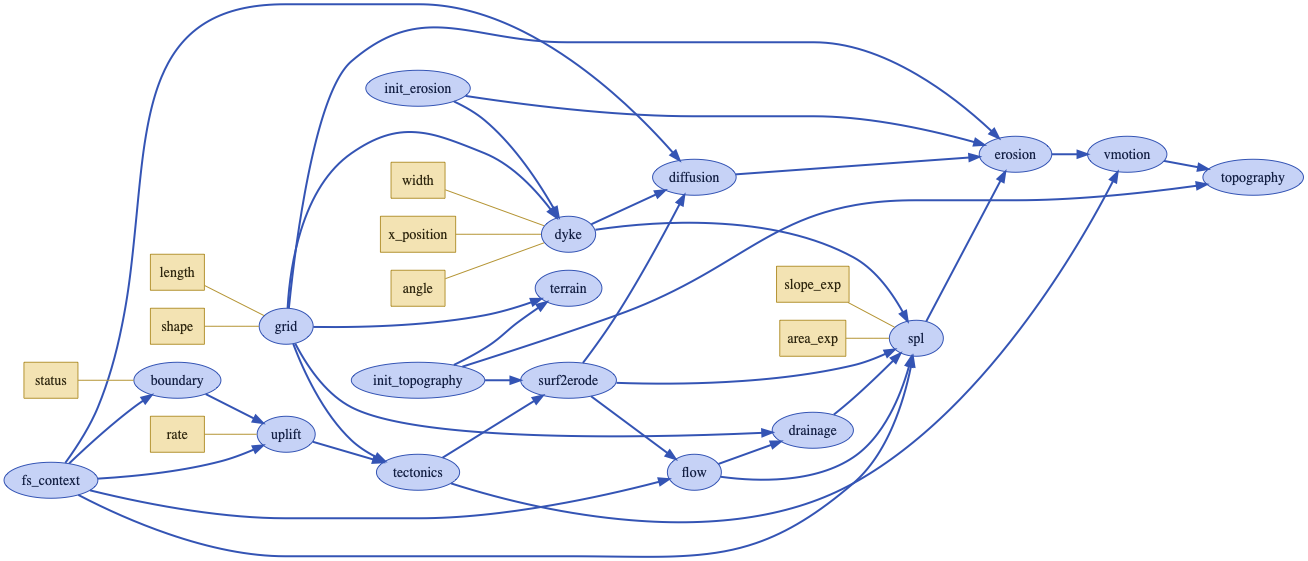

In [6]:
model.visualize(show_inputs=True)

## Model setup

**Note**: One important difference between this model and the example shown in the fastscapelib-fortran library is that linear diffusion is here computed using the same topographic surface than the one used for computing stream power channel erosion. In fastscapelib-fortran, diffusion is always computed after applying channel erosion on the topographic surface, which makes it more "tolerant" to large time steps.

While it is possible to customize `basic_model` to mimic the behavior of fastscapelib-fortran (e.g., by replacing the diffusion process by another (sub)class), we keep the "apply-combine" approach here for erosion processes for more flexibility. Even if those processes are applied sequentially, setting large time steps has a significant impact on the solution as the latter is is only partially implicit (when considering the processes all together).

In [7]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.arange(0, 4e7 + 2e4, 4e4),
        'out': np.arange(0, 4e7 + 4e5, 4e5),
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 201],
        'grid__length': [1e5, 1e5],
        'dyke': {
            'x_position': 1e4,
            'width': 2e3,
            'angle': 30.
        },
        'uplift__rate': 1e-3,
    },
    output_vars={
        'topography__elevation': 'out',
        'terrain__slope': 'out',
    }
)

in_ds

<xarray.Dataset>
Dimensions:           (out: 101, shape_yx: 2, time: 1001)
Coordinates:
  * time              (time) float64 0.0 4e+04 8e+04 ... 3.996e+07 4e+07
  * out               (out) float64 0.0 4e+05 8e+05 ... 3.92e+07 3.96e+07 4e+07
Dimensions without coordinates: shape_yx
Data variables:
    spl__slope_exp    int64 1
    boundary__status  <U11 'fixed_value'
    spl__area_exp     float64 0.4
    grid__shape       (shape_yx) int64 201 201
    grid__length      (shape_yx) float64 1e+05 1e+05
    dyke__x_position  float64 1e+04
    dyke__width       float64 2e+03
    dyke__angle       float64 30.0
    uplift__rate      float64 0.001

## Run the model

In [8]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

In [9]:
out_ds

<xarray.Dataset>
Dimensions:                (border: 4, out: 101, shape_yx: 2, time: 1001, x: 201, y: 201)
Coordinates:
  * border                 (border) <U6 'left' 'right' 'top' 'bottom'
  * out                    (out) float64 0.0 4e+05 8e+05 ... 3.96e+07 4e+07
  * time                   (time) float64 0.0 4e+04 8e+04 ... 3.996e+07 4e+07
  * x                      (x) float64 0.0 500.0 1e+03 ... 9.95e+04 1e+05
  * y                      (y) float64 0.0 500.0 1e+03 ... 9.95e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status       <U11 'fixed_value'
    dyke__angle            float64 30.0
    dyke__width            float64 2e+03
    dyke__x_position       float64 1e+04
    grid__length           (shape_yx) float64 1e+05 1e+05
    grid__shape            (shape_yx) int64 201 201
    spl__area_exp          float64 0.4
    spl__slope_exp         int64 1
    terrain__slope         (out, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    topography__elev

## Plot the outputs

Plot the local topographic gradient (slope) and the swath profile of elevations averaged along the y-axis.

In [10]:
import hvplot.xarray
import holoviews as hv
from xshade import hillshade


slope_plot = out_ds.terrain__slope.hvplot.image(
    x='x', y='y', clim=(0., 40.),
    width=550, height=450,
    cmap=plt.cm.plasma, groupby='out'
)

hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap=plt.cm.gray, alpha=0.6,
    colorbar=False, hover=False, groupby='out'
)

profile_plot = out_ds.topography__elevation.mean('y').hvplot.line(
    width=550, height=250, ylim=(0, 2000),
    groupby='out', legend='top_left',
)

hv.Layout((slope_plot * hillshade_plot) + profile_plot).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Overlay
         .Image.I  :Image   [x,y]   (terrain__slope)
         .Image.II :Image   [x,y]   (hillshade)
   .DynamicMap.II :DynamicMap   [out]
      :Curve   [x]   (topography__elevation)